<a href="https://colab.research.google.com/github/ProfDoeg/Colegio_Invisible/blob/main/14_cuaderno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#! rm Colegio_Invisible -r

In [ ]:
! git clone https://github.com/ProfDoeg/Colegio_Invisible.git

Cloning into 'Colegio_Invisible'...
remote: Enumerating objects: 1118, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 1118 (delta 91), reused 120 (delta 83), pack-reused 990
Receiving objects: 100% (1118/1118), 131.12 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (773/773), done.


In Notebook 11 we input data through a chain of op_returns. In Notebook 12 and 13 this evolved to embedding data from using op_returns embedded in parallel transactions. Parallel transactions are spent from UTXO's from the same transaction and can be broadcast simultaneously.

Here we take a hybrid approach, call them parallel chains.

We will need 
- a function that reads down the chain, appending op_returns
- a system that will grow the chain until the data clip is empty


In [ ]:
from PIL import Image
import numpy as np

what can we put into blockchain...
Op_Return
80 bytes and we will use 64 bytes for image data

each byte is made up of 8 binary values 1/0 called bits

64 bytes = 64*8...512 bits

We want to put image in single block

PROPOSAL:

16x16 image = 256 pixels

only get to use 2 bits per pixel

- 0,0  0 
- 0,1  64
- 1,0  128
- 1,1  192

1 byte [ , , , , , , , ]

1 byte can tell us color of 4 pixels
each one taking up 2 bits

In [ ]:
!ls Colegio_Invisible/img

In [ ]:
stego_image=Image.open('Colegio_Invisible/img/cat.png')
stego_image=stego_image.resize((32,32))
stego_image

In [ ]:
type(stego_image)

In [ ]:
stego_array = np.array(stego_image)
stego_array

**`uint8`** stands for unsigned 8-bit integer
- 8 binary 1/0 values
- that is one byte
- a number from 0-255
- two hex values like ff

In [ ]:
2**8

In [ ]:
stego_array.dtype

In [ ]:
stego_array.shape

In [ ]:
stego_array[:,:,:3]

In [ ]:
def grey_imgarr(imgarr):
  return imgarr[:,:,:3].mean(axis=2).astype('uint8')

In [ ]:
stego_array_grey=stego_array[:,:,:3].mean(axis=2).astype('uint8')
stego_array_grey.shape,stego_array_grey.dtype

In [ ]:
stego_array_grey

In [ ]:
stego_image_grey = Image.fromarray(stego_array_grey)
stego_image_grey

In [ ]:
def int_2_bit_array(num):
    bin_str=bin(num)
    bit_list=[int(bit) for bit in bin_str[2:]]
    bit_list=[0]*(8-len(bit_list))+bit_list
    bit_array=np.array(bit_list,dtype='uint8')
    return bit_array

In [ ]:
int_2_bit_array(255)

In [ ]:
int_2_bit_array(2)

In [ ]:
int_2_bit_array(64)

In [ ]:
int_2_bit_array(65)

In [ ]:
int_2_bit_array(68)

In [ ]:
int_2_bit_array(1)

In [ ]:
int_2_bit_array(0)

Goal:

- take image of 256 bytes and reduce each byte to 2 bit in form of 2 element array
- turn that all into 512 bits
- turn 512 bits into 64 bytes

# Generalize Standard For Images (MxN)

If we create a standard for the header that describes the data stored then we can choose the following paramenters:

- length
- width
- color dim 
- color bit count

In total the number of bits is the product of all the parameters

## Greyscale Image 

## RGB Image

## Two Channel Color Standard

## Four Channel

## General Color Dim



In [ ]:
def grey_imgarr(imgarr):
  return imgarr[:,:,:3].mean(axis=2).astype('uint8')

def message_2_bit_array(message,mode=None):
    '''This function takes in a message as string, bytestring or hextring.
    If hexstring input the set mode='hex' '''
    if type(message)==bytes:
        hex_str=message.hex()
    elif (type(message)==str):
        if mode not in ('hex','hexstring'):
            hex_str=message.encode().hex()
        else:
            hex_str=message
    else:
        print('fix the input and mode')
        return None
    
    num=int('0x'+hex_str,base=16)
    byte_len=(len(hex_str)+1)//2
    bit_len=byte_len*8
    bin_str=bin(num)
    bit_list=[int(bit) for bit in bin_str[2:]]
    bit_list=[0]*(bit_len-len(bit_list))+bit_list
    bit_array=np.array(bit_list,dtype='uint8')
    return bit_array

def bit_array_2_byte_str(bit_array):
    '''Convert bit array to a bytestring'''
    bit_list=[ str(bit) for bit in bit_array]
    bin_str='0b'+(''.join(bit_list))
    num=int(bin_str,base=2)
    return num.to_bytes(len(bit_array)//8,'big')

def bit_array_2_hex_str(bit_array):  
    '''Convert a bit array to a hexstring'''
    return bit_array_2_byte_str(bit_array).hex()

def bit_array_2_str(bit_array,encoding='utf-8'):
    '''Convert a bit array to a string'''
    return bit_array_2_byte_str(bit_array).decode(encoding)

def int2bitarray(x,bit=8):
  return message_2_bit_array(hex(x)[2:],mode='hex')[:bit]

def bitarray2int(b_arr):
  ln=b_arr.shape[0]
  scales=(2**np.arange(7,-1,-1))[:ln]
  return (b_arr*scales).sum()

def imgarr2bitarray(imgarr,bit=8):
  return np.array([ int2bitarray(it,bit) for it in imgarr.reshape(-1)]).reshape(-1)

def bitarray2imgarr(barrs,imgshape=(16,16),bit=2,color=1):
  lns=len(barrs.reshape(-1))
  #Bs=barrs.reshape(*imgshape,bit)
  intlst=[ bitarray2int(barrs.reshape(-1)[i:i+bit]) for i in range(0,lns,bit) ]
  intarr=np.array(intlst).reshape(*imgshape,color).astype('uint8')
  return intarr
 
def bitarray2imgarr_scale(barrs,imgshape=(16,16),bit=2,color=1):
  lns=len(barrs.reshape(-1))
  #Bs=barrs.reshape(*imgshape,bit)
  intlst=[ bitarray2int_scale(barrs.reshape(-1)[i:i+bit]) for i in range(0,lns,bit) ]
  intarr=np.array(intlst).reshape(*imgshape,color).astype('uint8')
  return intarr

In [ ]:
class bitimage():

  def __init__(self,imgpath,dims=(16,16),bit=2,color=1):
    from PIL import Image
    self.color=color
    self.bit=bit
    self.dims=list(dims)
    self.img_og=Image.open(imgpath)
    self.img_resize=self.img_og.resize(dims)
    self.grey=grey_imgarr(np.array(self.img_resize))
    self.img_grey=Image.fromarray(self.grey)
    self.bitarray=imgarr2bitarray(self.grey,bit)
    self.bitarray_color=imgarr2bitarray(np.array(self.img_resize)[:,:,:color],bit)
    self.newimg=Image.fromarray(bitarray2imgarr(self.bitarray,imgshape=dims[::-1],bit=bit,color=1).squeeze())
    self.newimg_color=Image.fromarray(bitarray2imgarr(self.bitarray_color,imgshape=dims[::-1],bit=bit,color=3).squeeze())
    self.bytestring=bit_array_2_byte_str(self.bitarray)
    self.bytestring_color=bit_array_2_byte_str(self.bitarray_color)




In [ ]:
!ls Colegio_Invisible/img

# Transform Image and Create Byte Encoding 

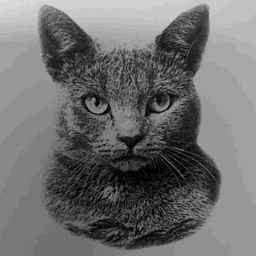

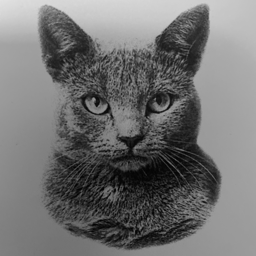

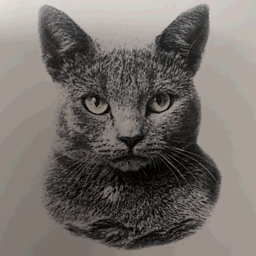

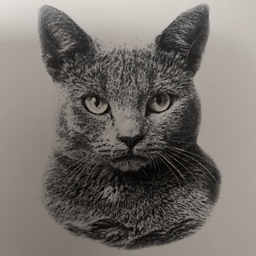

(512.0, 1536.0)

In [ ]:
bimg=bitimage('Colegio_Invisible/img/cat.png',dims=(256,256),bit=5,color=3)
display(bimg.newimg)
display(bimg.img_grey)
display(bimg.newimg_color)
display(bimg.img_resize)
len(bimg.bytestring)/80,len(bimg.bytestring_color)/80

# Create Embedding for Blockchain

In [ ]:
import hashlib 

message=bimg.bytestring_color
H=hashlib.sha256(message)

n=80
chunks = [message[i:i+n] for i in range(0, len(message), n)]

print(len(chunks))
print(len(chunks[-1]))

print(H.digest())

In [ ]:
header=b'\xc1\xdd\x00\x01\x03\xff\x01\x00\x40\x00\x40\x05'
text='Peter Bea'.encode()
print(len(header))
print(len(text))
header+text

In [ ]:
package=[header+text]+chunks
package

In [ ]:
! pip install eciespy eth_keys cryptos qrcode base58 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 2.0 MB 61.7 MB/s 
     |████████████████████████████████| 555 kB 40.7 MB/s 
     |████████████████████████████████| 105 kB 19.8 MB/s 
     |████████████████████████████████| 481 kB 40.1 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1236710 sha256=aa93fab3759d4a375f9526c4d4269cd10a07cda06ec996a77ab7e88f42ad86fc
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
  Created wheel for qrcode: filename=qrcode-7.3.1-py3-none-any.whl size=40402 sha256=a61edffa59f6fc106ec7ab242ed8edcdcd0cd916bbed4983f269e17a9928bca1
  Stored in directory: /root/.cache/pip/wheels/93/d7/39/a4111be2cfb8e679938aa671a37888b6afb1f9e7d748e94492
Successfully built cytoolz qrcode


In [ ]:
import pandas as pd
from cryptos.py3specials import safe_hexlify, from_string_to_bytes, from_int_to_byte, from_string_to_bytes
from cryptos import serialize,deserialize

import hashlib
import os
import getpass
import ecies
import eth_keys
import cryptos
import qrcode
import base58
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

def import_privKey(privkey_filepath,password=None):
    if password==None:
        password = getpass.getpass("Input password for decrypting keyfile: ")
    password=password.encode()
    f=open(privkey_filepath,'rb')
    decrypted_bytes=ecies.aes_decrypt(key=hashlib.sha256(password).digest(),cipher_text=f.read())
    privKey=eth_keys.keys.PrivateKey(decrypted_bytes)
    return privKey

def import_pubKey(pubkey_filepath):
    f=open(pubkey_filepath,'rb')
    privKey=eth_keys.keys.PublicKey(f.read())
    return privKey

def import_addr(addr_filepath):
    return open(addr_filepath,'rb').read().decode()

def only_conf(utxos):
    return [utxo for utxo in utxos
            if doge.fetchtx(utxo['output'].split(':')[0])['confirmations']>0]

def mk_opreturn(msg, rawtx=None, json=0):
    
    def op_push(data):
        if type(data) == bytes:
            bytedata=data
        else:
            bytedata=data.encode()
        import struct
        if len(data) < 0x4c:
            return from_int_to_byte(len(bytedata)) + bytedata
        elif len(data) < 0xff:
            return from_int_to_byte(76) + struct.pack('<B', len(bytedata)) + bytedata
        elif len(data) < 0xffff:
            return from_int_to_byte(77) + struct.pack('<H', len(bytedata)) + bytedata
        elif len(data) < 0xffffffff:
            return from_int_to_byte(78) + struct.pack('<I', len(bytedata)) + bytedata
        else: raise Exception("Input data error. Rawtx must be hex chars" \
                            + "0xffffffff > len(data) > 0")

    orhex = safe_hexlify(b'\x6a' + op_push(msg))
    orjson = {'script' : orhex, 'value' : 0}
    if rawtx is not None:
        try:
            txo = deserialize(rawtx)
            if not 'outs' in txo.keys(): raise Exception("OP_Return cannot be the sole output!")
            txo['outs'].append(orjson)
            newrawtx = serialize(txo)
            return newrawtx
        except Exception as E:
            print(E)
            print(type(E))
            raise Exception("Raw Tx Error!")
    return orhex if not json else orjson

# Load Keys and Addresses

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! cp drive/MyDrive/cinv/llaves.zip llaves.zip 
! unzip llaves.zip

In [ ]:
from IPython.display import Image
qr=Image('llaves/mi_addr.png')

privKey=import_privKey('llaves/mi_prv.enc','')
pub=import_pubKey('llaves/mi_pub.bin').to_hex()
addr=import_addr('llaves/mi_addr.bin')

display(qr)
display(pub)
display(addr)

# Inspect Outputs

In [ ]:
doge=cryptos.Doge()
#addy=doge.privtoaddr(privkeyhex)
doge_unspents=only_conf( doge.unspent(addr) )
doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents])
doge_unspent_total/10**8

# Create UTXO set for Enscription

In [ ]:
tip=13_70_000_000
available=doge_unspent_total-tip
n=len(package)
gift=int(available/n)
outputs=[{'value':gift , 'address': addr} for i in range(len(package))]
setup_tx=doge.mktx(doge_unspents,outputs)

In [ ]:
doge.signall(setup_tx,privKey.to_hex()[2:])

In [ ]:
tip/(len(cryptos.serialize(setup_tx))/2)/100000

In [ ]:
funding=doge.pushtx(cryptos.serialize(setup_tx))
funding

In [ ]:
doge.fetchtx(funding['data']['txid'])

In [ ]:
#UTXO set
sparkle_unspents=only_conf( doge.unspent(addr) )
sparkle_unspents

In [ ]:
len(sparkle_unspents)

In [ ]:
input_monolists=[ [elem] for elem in sparkle_unspents]

# Send 32*3 + 1 UTXOS from same txn back to self

# Create list of transactions each containing op_return

In [ ]:
write_tip=1_37_000_000
outputs=[ [{'value':elem['value']-write_tip , 'address': addr}] for elem in sparkle_unspents]

In [ ]:
outputs

        doge_serial_tx=cryptos.serialize(doge_tx)
        doge_inscribed_serial_tx=mk_opreturn( op_return , doge_serial_tx)
        doge_inscribed_tx=cryptos.deserialize(doge_inscribed_serial_tx)
        doge_signed_inscribed_tx=doge.signall(doge_inscribed_tx,privkeyhex)
        broadcast_doge_signed_inscribed_tx=doge.pushtx(doge_signed_inscribed_tx)

In [ ]:
txns=[ doge.mktx(input_monolists[i],outputs[i]) for i in range(len(package))]

In [ ]:
serial_txns=[cryptos.serialize(tx) for tx in txns]

In [ ]:
inscribed_serial_txs=[mk_opreturn( package[i] , serial_txns[i]) for i in range(len(package))]

In [ ]:
1.37/len(inscribed_serial_txs[0])/2

In [ ]:
inscribed_serial_txs

In [ ]:
inscribed_txs=[cryptos.deserialize(elem) for elem in inscribed_serial_txs]

In [ ]:
signed_inscribed_txs=[doge.signall(elem,privKey.to_hex()[2:]) for elem in inscribed_txs]

In [ ]:
broadcasts=[doge.pushtx(elem) for elem in signed_inscribed_txs]
broadcasts

In [ ]:
broadcasts[0]['data']['txid']

# Everything is Retrievable From the TX Hash of Header Transaction 

The first transaction, spending the first output of the prepared UTXOs

```
53ae86951b38d91cc01a90e7cf9e7089ffff0a4b81a46fcd02a104d696247cb2

90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f
```

Or use the UTXO set transactions

```
c1542c10399a09a5471799133c472a6652d5cb3b7b421e1a7e80e2039f5b393b

a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9
```

In [ ]:
[doge.fetchtx(broadcast['data']['txid'])['confirmations'] for broadcast in broadcasts]

In [ ]:
doge.block_height()

# Automate Reading From Dogecoin Blockchain

In [ ]:
!pip install cryptos

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 5.9 MB/s 


In [ ]:
doge=cryptos.Doge()
doge.fetchtx('a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9')

{'blockhash': '4fc98c5553dc5fe736db42ff1aab70c70bac53db4c53552b26374e2b80535884',
 'confirmations': 13533,
 'inputs': [{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
   'from_output': {'output_no': 0,
    'txid': '53ae86951b38d91cc01a90e7cf9e7089ffff0a4b81a46fcd02a104d696247cb2'},
   'input_no': 0,
   'script': '304402203ae7b7a459935093fe7534f8d728592047eba5efeb1501936f66da97519bdad70220340831c96477fb031ba7ae694da6eda389d8203ef17a8dd81fbc7d045f7ded2801 047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
   'sequence': 4294967295,
   'type': 'pubkeyhash',
   'value': '5.17545453',
   'witness': None},
  {'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
   'from_output': {'output_no': 0,
    'txid': '7de555db92ec394ebb6050928c9b70fd34bf6fb2ed5e33e33c3f4b9dfc9e8900'},
   'input_no': 1,
   'script': '3045022100d6bc4339f8616e77d69357f61ad273b5f77ac5e27364abeccab987856af5557f022059e182df185ea1ae3671f516165861

In [ ]:
import requests
bea_txn='a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9'

r = requests.get(f'https://sochain.com/api/v2/tx/DOGE/{bea_txn}')
r.status_code

200

In [ ]:
type(r.text)

str

In [ ]:
def get_output_spend_txns(txn_ident):
  import requests
  import json
  r = requests.get(f'https://sochain.com/api/v2/tx/DOGE/{txn_ident}')
  return [out['spent']['txid'] for out in json.loads(r.text)['data']['outputs']]

In [ ]:
import requests
import json
#bea_txn='90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f'
r = requests.get(f'https://sochain.com/api/v2/tx/DOGE/{bea_txn}')
bea_json=json.loads(r.text)
bea_json


{'code': 200,
 'data': {'block_no': 4224224,
  'blockhash': '4fc98c5553dc5fe736db42ff1aab70c70bac53db4c53552b26374e2b80535884',
  'confirmations': 15355,
  'fee': '13.70000014',
  'inputs': [{'address': 'D6zKNnkupqRbkB9p5rwix8QiobQWJazjyX',
    'input_no': 0,
    'received_from': {'output_no': 0,
     'txid': '53ae86951b38d91cc01a90e7cf9e7089ffff0a4b81a46fcd02a104d696247cb2'},
    'script_asm': '304402203ae7b7a459935093fe7534f8d728592047eba5efeb1501936f66da97519bdad70220340831c96477fb031ba7ae694da6eda389d8203ef17a8dd81fbc7d045f7ded2801 047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
    'script_hex': '47304402203ae7b7a459935093fe7534f8d728592047eba5efeb1501936f66da97519bdad70220340831c96477fb031ba7ae694da6eda389d8203ef17a8dd81fbc7d045f7ded280141047c88e9a4df6e9f45656c10bf66f28e28be235a15b64820b254f1b9eb2738314e6769f5c94da0c7640ffe76dcffca053b07a0804cd53a1c51ad03bfe0133ce8c5',
    'value': '5.17545453',


In [ ]:
get_output_spend_txns('a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9')

['90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f',
 'cf0f325d00cc33cedde905f1132855c569ae573f3aa1493c837652aeebee18bc',
 'c682f3de33dd6e882d6cbf499d28d6ebd87fecd2fad7108065fa5390d7a00458',
 '7f9b29b2044836633e01d4d47f503f53633433eaa4916e816ac7e59bc3adc60f',
 '2ae27a0deaa2d5d9552cddca69d230f3805d96a33d9f7b23441545fea3449b15',
 '7d2b514eec23fd6e5fe54b9ff6ef960e497006bb67e9d9346dc17afa773441e0',
 'e37652ffd099b7228e54c6c5c1409ae005c18f4d8b4ba84e006311c056a311f2',
 '0238f55d0b9f7072fbb8d7c55c75624cc61c3b9bf3a49710ddc5c1b8ee370d59',
 '40a1252151a21a47834a1e34f467ccdcf9eae17aba7a12334e02d1aae4193e4a',
 'fc77eabae6b98782fe9e53a4d1682d8a5da798aec4c77992b947913e03c3f314',
 '0f888cafb1a66e00cb7a9186a2b0ec88424d1ca17c84f9087d45d8dae80ebcea',
 'c8b41a54da2a57288d14e31fb380dc74e5866b4341e5c279a4e1c596c3aa2ea0',
 'd1265f7ae5cf0cde3bb1450ea5623f17cf5c86ad5064f64925421645e54c95e8',
 'c60866a55c283d3cbb4ffe09dd678a7fe2e48c8304e8472a41889ffbbc7eb277',
 '5f746e2bf3f21b192430938e340ae3ae

In [ ]:
x={1:2}
x.get(3)
x[3]

KeyError: ignored

In [ ]:
def get_op_return(txn_ident):
  import requests
  import json
  
  r = requests.get(f'https://sochain.com/api/v2/tx/DOGE/{txn_ident}')
  outs=json.loads(r.text)['data']['outputs']
  asm=outs[-1]['script_asm']
  return (asm[10:] if 'OP_RETURN' in asm else None),outs[0]['spent']['txid'] if outs[0]['spent'] else None #( outs[0]['spent']['txid'] if 'spent'in list(outs[0].keys()) else None)

In [ ]:
get_op_return('90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f')

('c1dd000103ff010040004005506574657220426561', None)

In [ ]:
get_op_return('a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9')

(None, '90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f')

In [ ]:
get_op_return('a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9')

(None, '90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f')

In [ ]:
get_output_spend_txns(bea_txn)

['90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f',
 'cf0f325d00cc33cedde905f1132855c569ae573f3aa1493c837652aeebee18bc',
 'c682f3de33dd6e882d6cbf499d28d6ebd87fecd2fad7108065fa5390d7a00458',
 '7f9b29b2044836633e01d4d47f503f53633433eaa4916e816ac7e59bc3adc60f',
 '2ae27a0deaa2d5d9552cddca69d230f3805d96a33d9f7b23441545fea3449b15',
 '7d2b514eec23fd6e5fe54b9ff6ef960e497006bb67e9d9346dc17afa773441e0',
 'e37652ffd099b7228e54c6c5c1409ae005c18f4d8b4ba84e006311c056a311f2',
 '0238f55d0b9f7072fbb8d7c55c75624cc61c3b9bf3a49710ddc5c1b8ee370d59',
 '40a1252151a21a47834a1e34f467ccdcf9eae17aba7a12334e02d1aae4193e4a',
 'fc77eabae6b98782fe9e53a4d1682d8a5da798aec4c77992b947913e03c3f314',
 '0f888cafb1a66e00cb7a9186a2b0ec88424d1ca17c84f9087d45d8dae80ebcea',
 'c8b41a54da2a57288d14e31fb380dc74e5866b4341e5c279a4e1c596c3aa2ea0',
 'd1265f7ae5cf0cde3bb1450ea5623f17cf5c86ad5064f64925421645e54c95e8',
 'c60866a55c283d3cbb4ffe09dd678a7fe2e48c8304e8472a41889ffbbc7eb277',
 '5f746e2bf3f21b192430938e340ae3ae

In [ ]:
get_output_spend_txns('a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9')

['90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f',
 'cf0f325d00cc33cedde905f1132855c569ae573f3aa1493c837652aeebee18bc',
 'c682f3de33dd6e882d6cbf499d28d6ebd87fecd2fad7108065fa5390d7a00458',
 '7f9b29b2044836633e01d4d47f503f53633433eaa4916e816ac7e59bc3adc60f',
 '2ae27a0deaa2d5d9552cddca69d230f3805d96a33d9f7b23441545fea3449b15',
 '7d2b514eec23fd6e5fe54b9ff6ef960e497006bb67e9d9346dc17afa773441e0',
 'e37652ffd099b7228e54c6c5c1409ae005c18f4d8b4ba84e006311c056a311f2',
 '0238f55d0b9f7072fbb8d7c55c75624cc61c3b9bf3a49710ddc5c1b8ee370d59',
 '40a1252151a21a47834a1e34f467ccdcf9eae17aba7a12334e02d1aae4193e4a',
 'fc77eabae6b98782fe9e53a4d1682d8a5da798aec4c77992b947913e03c3f314',
 '0f888cafb1a66e00cb7a9186a2b0ec88424d1ca17c84f9087d45d8dae80ebcea',
 'c8b41a54da2a57288d14e31fb380dc74e5866b4341e5c279a4e1c596c3aa2ea0',
 'd1265f7ae5cf0cde3bb1450ea5623f17cf5c86ad5064f64925421645e54c95e8',
 'c60866a55c283d3cbb4ffe09dd678a7fe2e48c8304e8472a41889ffbbc7eb277',
 '5f746e2bf3f21b192430938e340ae3ae

In [ ]:
get_op_return('c1542c10399a09a5471799133c472a6652d5cb3b7b421e1a7e80e2039f5b393b')

(None, '53ae86951b38d91cc01a90e7cf9e7089ffff0a4b81a46fcd02a104d696247cb2')

In [ ]:
def get_op_returns(tx_head,prefix=''):
  op_ret,next_txn=get_op_return(tx_head)
  if (op_ret and next_txn):
    return get_op_returns(next_txn,prefix+op_ret)
  if op_ret==None:
    return prefix
  else:
    return prefix+op_ret

In [ ]:
print(bytes.fromhex(get_op_returns('6de5b84940f73653196800c747f3a6f86752e4dcc5ccbb3fbc81fcb2d20e1672')).decode('latin'))

Blue Monday

How does it feel
When you treat me like you do
your hands upon me
And told me who you are?
I thought I was mistaken
hought I heard your words
Tell me, how do I feel?
?
Those who came before me
Lived through their vocations
 completion
They will turn away no more
And I still find it so hard
hat I need to say
But I'm quite sure that you'll tell me
eel today
I see a ship in the harbor
I can and shall obey
or your misfortunes
I'd be a heavenly person today
ken
And I thought I heard you speak
Tell me how do I feel?
should I feel?
Now I stand here waiting
I thought I told you to leave me
WhiÝ
le I walked down to the beach
Tell me, how does it feel
s cold?
How does it feel?
How does it feel?
How does it feel?
I told you to leave me
While I walked down to the beach
 feel
When your heart grows cold


In [ ]:
get_op_returns('90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f')

'c1dd000103ff010040004005506574657220426561'

In [ ]:
full_op=get_op_returns('74de5e9bf0c292287e08c201d26676e26a5c2f21ddb639e9268af6d52d0e0c1c')

In [ ]:
A= [get_op_returns(trans) for trans in get_output_spend_txns('a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9')]

In [ ]:
A

['c1dd000103ff010040004005506574657220426561',
 '841f28c230841ee7b9ce6b5cd639ad7b5af739ee73dce83df184230846108c6318c65294a529ce739d273a5294a52b4a56b5b56d6adad5b5eb6bdad7b5af5b5eb6bd6d7adaf5b5ed6c5af8e73bdef79d',
 'ef39ddf39ef7b18cd6d79d2b39d2b5b529594a7294a319423184630846108421083e0f7c1ef841ef8c1ef739ed6bdcd735ad631ac639ac735af735ee73dce83df07be0f7c6108c2118c6318ca529ce73',
 '9ce739ce749ce94a5694adad7ad6d4adab5b56b6adaf6b5f18cdaf8adaf5ade95b5f19f7bdef7b7ce6b7be77bdef6d7c4e95a52b6b5e94aca5394a518c65295ad794a708421083df07be0f7c20f841ef',
 '7358e6b1cd6bdad7358d631ac5b58c7358e6b5ee73dce7b9d07be0f7c1f084211842318ca5294a5294a529ca539ce75ad6f7c5ad7ad6d4a5694ad295a52b4ad73ad6f9cceb55b5eb5b6f9cffffffffde',
 'ff7bdf7bddefad6bce95c6739d6b18cd6b694a76b5bbdef39cc6335ad61083def7bdf07c20f7bdef7358e6b1cd639ac6b18d62d8b5b58c6b18e631cd6bdce7b9cf73a0f7c1ef83df1842528ca5194a52',
 '94a52956b5ad6d294eb5b6339c6313a5274a5294a5293a5294adaf7bdf1ad6fbdeffffffffffffdef77bdffffbdf294ad295df39ef7bdef739cdef7defb9ce

In [ ]:
print(bytes.fromhex(full_op))

In [ ]:
import numpy as np
import cryptos
from PIL import Image

def read_image(txn_id):
  doge=cryptos.Doge()
  img_header_tx_data=doge.fetchtx(txn_id)
  op_return=img_header_tx_data['outputs'][1]['script'][10:]
  utxo_id=img_header_tx_data['inputs'][0]['from_output']['txid']
  blk_height= doge.block_height(txn_id)
  cand_txns=doge.block_info(blk_height)['tx_hashes'][1:]+doge.block_info(blk_height-1)['tx_hashes'][1:]+doge.block_info(blk_height+1)['tx_hashes'][1:]+doge.block_info(blk_height+2)['tx_hashes'][1:]
  cand_txns_info=[(cand,doge.fetchtx(cand)) for cand in cand_txns]
  img_txn_info=[ ( info['inputs'][0]['from_output']['output_no'],info['outputs'][1]['script'][10:] ) for (_,info) in cand_txns_info if info['inputs'][0]['from_output']['txid']==utxo_id]
  img_data_list=sorted(img_txn_info)
  hex_header=img_data_list[0][1]
  img_hex = ''.join([elem[1] for elem in img_data_list[1:]])
  image_bytes=bytes.fromhex(img_hex)
  L=int(hex_header[14:18],16)
  W=int(hex_header[18:22],16)
  B=int(hex_header[22:24],16)
  print(L,W,B)
  print(len(img_data_list))
  sparkle_bits=message_2_bit_array(image_bytes,mode=None)
  spark_array=bitarray2imgarr(sparkle_bits,imgshape=(L,W),bit=B,color=1).squeeze()
  return op_return,spark_array
  
def read_image_color(txn_id):
  doge=cryptos.Doge()
  img_header_tx_data=doge.fetchtx(txn_id)
  op_return=img_header_tx_data['outputs'][1]['script'][10:]
  utxo_id=img_header_tx_data['inputs'][0]['from_output']['txid']
  blk_height= doge.block_height(txn_id)
  cand_txns=doge.block_info(blk_height)['tx_hashes'][1:]+doge.block_info(blk_height-1)['tx_hashes'][1:]+doge.block_info(blk_height+1)['tx_hashes'][1:]+doge.block_info(blk_height+2)['tx_hashes'][1:]
  cand_txns_info=[(cand,doge.fetchtx(cand)) for cand in cand_txns]
  img_txn_info=[ ( info['inputs'][0]['from_output']['output_no'],info['outputs'][1]['script'][10:] ) for (_,info) in cand_txns_info if info['inputs'][0]['from_output']['txid']==utxo_id]
  img_data_list=sorted(img_txn_info)
  hex_header=img_data_list[0][1]
  img_hex = ''.join([elem[1] for elem in img_data_list[1:]])
  image_bytes=bytes.fromhex(img_hex)
  L=int(hex_header[14:18],16)
  W=int(hex_header[18:22],16)
  B=int(hex_header[22:24],16)
  print(L,W,B)
  print(len(img_data_list))
  sparkle_bits=message_2_bit_array(image_bytes,mode=None)
  spark_array=bitarray2imgarr(sparkle_bits,imgshape=(L,W),bit=B,color=3).squeeze()
  return op_return,spark_array
  

In [ ]:
def read_image_fund(txn_id):
  doge=cryptos.Doge()
  List=get_output_spend_txns(txn_id)
  #img_header_tx_data=doge.fetchtx(L[0])
  #op_return=img_header_tx_data['outputs'][1]['script'][10:]
  img_data_list=[doge.fetchtx(elem)['outputs'][1]['script'][10:] for elem in List ]
  hex_header=img_data_list[0]
  img_hex = ''.join([elem for elem in img_data_list[1:]])
  image_bytes=bytes.fromhex(img_hex)
  L=int(hex_header[14:18],16)
  W=int(hex_header[18:22],16)
  B=int(hex_header[22:24],16)
  print(L,W,B)
  print(len(img_data_list))
  sparkle_bits=message_2_bit_array(image_bytes,mode=None)
  spark_array=bitarray2imgarr(sparkle_bits,imgshape=(L,W),bit=B,color=1).squeeze()
  return hex_header,spark_array

def read_image_fund_color(txn_id):
  doge=cryptos.Doge()
  List=get_output_spend_txns(txn_id)
  #img_header_tx_data=doge.fetchtx(L[0])
  #op_return=img_header_tx_data['outputs'][1]['script'][10:]
  img_data_list=[doge.fetchtx(elem)['outputs'][1]['script'][10:] for elem in List ]
  hex_header=img_data_list[0]
  img_hex = ''.join([elem for elem in img_data_list[1:]])
  image_bytes=bytes.fromhex(img_hex)
  L=int(hex_header[14:18],16)
  W=int(hex_header[18:22],16)
  B=int(hex_header[22:24],16)
  print(L,W,B)
  print(len(img_data_list))
  sparkle_bits=message_2_bit_array(image_bytes,mode=None)
  spark_array=bitarray2imgarr(sparkle_bits,imgshape=(L,W),bit=B,color=3).squeeze()
  return hex_header,spark_array

In [ ]:

op_ret,sp_ar=read_image('53ae86951b38d91cc01a90e7cf9e7089ffff0a4b81a46fcd02a104d696247cb2')

64 64 5
33


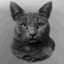

In [ ]:
from PIL import Image
Image.fromarray(sp_ar)

In [ ]:
op_ret_color,sp_ar_color=read_image_color('90c01813156e594c4dbe8bd39436597c68ffaaa201c458f9c1ccae3e86d2c33f')

64 64 5
97


In [ ]:

sp_ar_color.shape

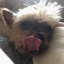

In [ ]:
Image.fromarray(sp_ar_color)

In [ ]:
op_ret_color

In [ ]:
bytes.fromhex(op_ret_color[24:]).decode()

In [ ]:
OPR,IMG=read_image_fund('c1542c10399a09a5471799133c472a6652d5cb3b7b421e1a7e80e2039f5b393b')

64 64 5
33


c1dd000103ff000040004005537061726b6c65f09f9088e2808de2ac9b4d61676963616c436174f09f9088e2808de2ac9be29ca8f09f929c466f7665766572f09f929ce29ca8


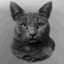

In [ ]:
print(OPR)
Image.fromarray(IMG)

In [ ]:
OPR_c,IMG_c=read_image_fund_color('a01e8625d653f4a8686b5b9e20ca653e59ebcd8bf2ca2a7b8370fdc52417f7b9')

64 64 5
97


c1dd000103ff010040004005506574657220426561


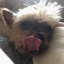

In [ ]:
print(OPR_c)
Image.fromarray(IMG_c)

In [ ]:
class Cadena():

  def __init__(self,prvkey,data,root_txn):
    self.data=data
    self.doge=doge=cryptos.Doge()
    self.clip=[self.data[i:i+80] for i in range(0,len(self.data),80) ]
    self.og_len=len(self.clip)
    






def embed_message_list(L,privkeyhex,tip=2_00_000_000):
    import time
    txn_ids=[]
    doge=cryptos.Doge()
    addy=doge.privtoaddr(privkeyhex)
    doge_unspents=only_conf( doge.unspent(addy) )
    doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents])
    if ( tip*len(L) + 3_00_000_000 ) > doge_unspent_total:
        raise Exception("Not enough coins available")
    # at this point we know we have enough coins...
    # now we will iterate through the list
    for op_return in L:
        print(op_return)
    # make sure to wait for utxos to confirm, if not wait 10 sec
        while True:
            doge_unspents=only_conf( doge.unspent(addy) )
            if doge_unspents != []:
              print('COINS UP')
              break
            time.sleep(20)
        doge_unspent_total=sum([unspent['value'] for unspent in doge_unspents]) 
        doge_gift=doge_unspent_total-tip
        doge_outputs=[ {'value':doge_gift , 'address': addy}]
        doge_tx=doge.mktx(doge_unspents,doge_outputs)
        doge_serial_tx=cryptos.serialize(doge_tx)
        doge_inscribed_serial_tx=mk_opreturn( op_return , doge_serial_tx)
        doge_inscribed_tx=cryptos.deserialize(doge_inscribed_serial_tx)
        doge_signed_inscribed_tx=doge.signall(doge_inscribed_tx,privkeyhex)
        broadcast_doge_signed_inscribed_tx=doge.pushtx(doge_signed_inscribed_tx)
        txn_ids.append(broadcast_doge_signed_inscribed_tx['data']['txid'])
    return txn_ids